# Pix2Pix

## Adapted from TensorFlow's [Pix2Pix tutorial notebook](https://www.tensorflow.org/tutorials/generative/pix2pix)

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 15 seconds on a single V100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
!pip install -U tensorboard

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.4.0)


In [ ]:
# Your drive might be named 'gdrive' rather than 'drive'
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Week 9/')
os.listdir('.')

Mounted at /content/drive


['model.png', 'logs', 'training_checkpoints', '9.x_pix2pix.ipynb']

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

### Download the data

In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 6s 0us/step


### Global parameters

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

### Exercise: Image loading function

Each image file contains contains two images: a segmented facade and a ground truth image of the actual building containing that facade. This function splits the array containing both images into two arrays.

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2

  ### START CODE HERE ###
  # Assign the first half of Dimension 1 of the image to real_image
  real_image = image[:, :w]
  # Assign the second half of Dimension 1 of the image to input_image
  input_image = image[:, w:]
  # Ensure that the pixel values are represented as TF 32-bit floating point numbers
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  ### END CODE HERE ###

  return input_image, real_image

### Display a segmented facade and the associated building

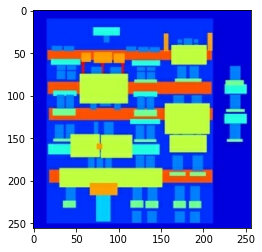

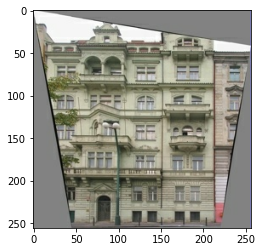

In [ ]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

### Exercise: Image resizing function

Resize both the input and real images to a given `height` and `width`. You might find [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize) useful. Use nearest neighbor resizing.

In [ ]:
def resize(input_image, real_image, height, width):
  ### START CODE HERE ###
  input_image = tf.image.resize(input_image, (height, width), method='nearest')
  real_image = tf.image.resize(real_image, (height, width), method='nearest')
  ### END CODE HERE ###
  return input_image, real_image

### Exercise: Image cropping function

Randomly crop an `img_height` x `img_width` area from both the (typically resized) input and real images. Make sure you crop the same area from both images, or your model training and evaluation will be useless. You may find [`tf.stack()`](https://www.tensorflow.org/api_docs/python/tf/stack) and [`tf.image.random_crop()`](https://www.tensorflow.org/api_docs/python/tf/image/random_crop) helpful.

In [ ]:
def random_crop(input_image, real_image, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
  ### START CODE HERE ###
  # Concatenate/stack the input and real images (in that order) along the 0 dimension
  stacked_image = tf.stack((input_image, real_image), axis=0)
  # Crop an img_height by img_width area out of the stacked_image
  # Return cropped_image as an array with 2 elements in its 0 dimension, 
  # one for the input and one for the real image
  cropped_image = tf.image.random_crop(stacked_image, (2, img_height, img_width, 3))
  ### END CODE HERE ###
  return cropped_image[0], cropped_image[1]

### Exercise: Image normalization function

Normalize the input and real images' pixel values so they fall in the range [-1, 1]

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  ### START CODE HERE ###
  input_image = (input_image - 128) / 128
  real_image = (real_image - 128) / 128
  ### END CODE HERE ###
  return input_image, real_image

### Exercise: Random jitter function

Resize, randomly crop, and randomly mirror an (input, real) image pair. You might find [`tf.image.flip_left_right()`](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right) useful. 

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  ### START CODE HERE ###
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  ### END CODE HERE ###
  return input_image, real_image

As you can see in the images below
that they are going through random jittering
Random jittering as described in the paper is to

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

### Exercise: Load and preprocess train and test images

In [ ]:
def load_image_train(image_file):
  ### START CODE HERE ###
  # Load
  input_image, real_image = load(image_file)
  # Random jitter
  input_image, real_image = random_jitter(input_image, real_image)
  # Normalize
  input_image, real_image = normalize(input_image, real_image)
  ### END CODE HERE ###
  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  ### START CODE HERE ###
  # Load
  input_image, real_image = load(image_file)
  # Resize to IMG_HEIGHT by IMG_WIDTH
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  # Normalize
  input_image, real_image = normalize(input_image, real_image)
  ### END CODE HERE
  return input_image, real_image

## Input Pipeline

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [ ]:
OUTPUT_CHANNELS = 3

### Exercise: Downsampling block

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  ### START CODE HERE ###

  # Initialize the parameters so they are normally distributed, 
  # with a mean of 0 and standard deviation of 0.02
  initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
  
  # Instantiate a sequential block
  result = tf.keras.Sequential()
  
  # Add a 2D convolutional layer
  # Use a stride of 2, same padding, and the initializer defined above
  # DON'T use a bias vector
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  
  # Add batch normalization, if appropriate
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  
  # Add a leaky ReLU activation
  result.add(tf.keras.layers.LeakyReLU())
  
  ### END CODE HERE ###
  
  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


### Exercise: Upsampling block

In [ ]:
def upsample(filters, size, apply_dropout=False):
  ### START CODE HERE ###

  # Initialize the parameters so they are normally distributed, 
  # with a mean of 0 and standard deviation of 0.02
  initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)

  # Instantiate a sequential block
  result = tf.keras.Sequential()
  
  # Add a 2D transposed convolutional layer
  # Use a stride of 2, same padding, and the initializer defined above
  # DON'T use a bias vector
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                             padding='same',
                                             kernel_initializer=initializer,
                                             use_bias=False))
  
  # Add batch normalization
  result.add(tf.keras.layers.BatchNormalization())

  # Add dropout with a probability of 0.5, if appropriate
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
  
  # Add a ReLU activation
  result.add(tf.keras.layers.ReLU())

  ### END CODE HERE ###

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


### Exercise: Build the Pix2Pix generator

In [ ]:
def Generator():
  ### START CODE HERE ###

  # Define a keras input layer with shape [256,256,3]
  inputs = tf.keras.layers.Input(shape=(256, 256, 3))

  # Define a stack of downsampling blocks
  # Use the output shapes at the right of each line to determine the arguments of each downsampling block
  # Don't apply batch normalization to the first block, but do apply it to the rest
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (batch size, 128, 128, 64)
    downsample(128, 4), # (batch size, 64, 64, 128)
    downsample(256, 4), # (batch size, 32, 32, 256)
    downsample(512, 4), # (batch size, 16, 16, 512)
    downsample(512, 4), # (batch size, 8, 8, 512)
    downsample(512, 4), # (batch size, 4, 4, 512)
    downsample(512, 4), # (batch size, 2, 2, 512)
    downsample(512, 4), # (batch size, 1, 1, 512)
  ]

  # Define a stack of upsampling blocks
  # Use the output shapes at the right of each line to determine the arguments of each upsampling block
  # Apply dropout regularization to the first 3 blocks, but don't apply it to the rest
  # Leo's note: filters are halved because we concatenate skip connections.
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (batch size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (batch size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (batch size, 8, 8, 1024)
    upsample(512, 4), # (batch size, 16, 16, 1024)
    upsample(256, 4), # (batch size, 32, 32, 512)
    upsample(128, 4), # (batch size, 64, 64, 256)
    upsample(64, 4), # (batch size, 128, 128, 128)
  ]

  # Initialize the parameters so they are normally distributed, 
  # with a mean of 0 and standard deviation of 0.02
  initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
  
  # Define the final layer as a 2D transposed convolution with 
  # OUTPUT_CHANNELS filters, kernel size of 4, stride of 2, same padding, 
  # the initializer defined above, and tanh activation
  last = tf.keras.layers.Conv2DTranspose(
      OUTPUT_CHANNELS, 4, strides=2, padding='same',
      kernel_initializer=initializer,
      activation='tanh') # (batch size, 256, 256, 3)

  # Now that we've defined the generator's layers, let's assemble them into a network 
  # with the keras functional API

  # Start with the input layer
  x = inputs

  # Downsampling through the model
  skips = []
  # Loop through the downsampling blocks
  for down in down_stack:
    # Apply the current downsampling block
    x = down(x)
    # Append the downsampled data to the skips list
    # We'll use it for upsampling later
    skips.append(x)
  
  # Take all but the last element in the skips list and reverse them
  skips = skips[:-1][::-1]

  # Upsampling and establishing the skip connections
  # Loop through the zipped upsampling stack and skips list
  for up, skip in zip(up_stack, skips):
    # Apply the current upsampling block
    x = up(x)
    # Concatenate the upsampled data and the appropriately downsampled data from the skips list
    x = tf.keras.layers.concatenate((x, skip))

  # Apply the last layer
  x = last(x)
  ### END CODE HERE ###
  return tf.keras.Model(inputs=inputs, outputs=x)

### Visualize the generator's architecture

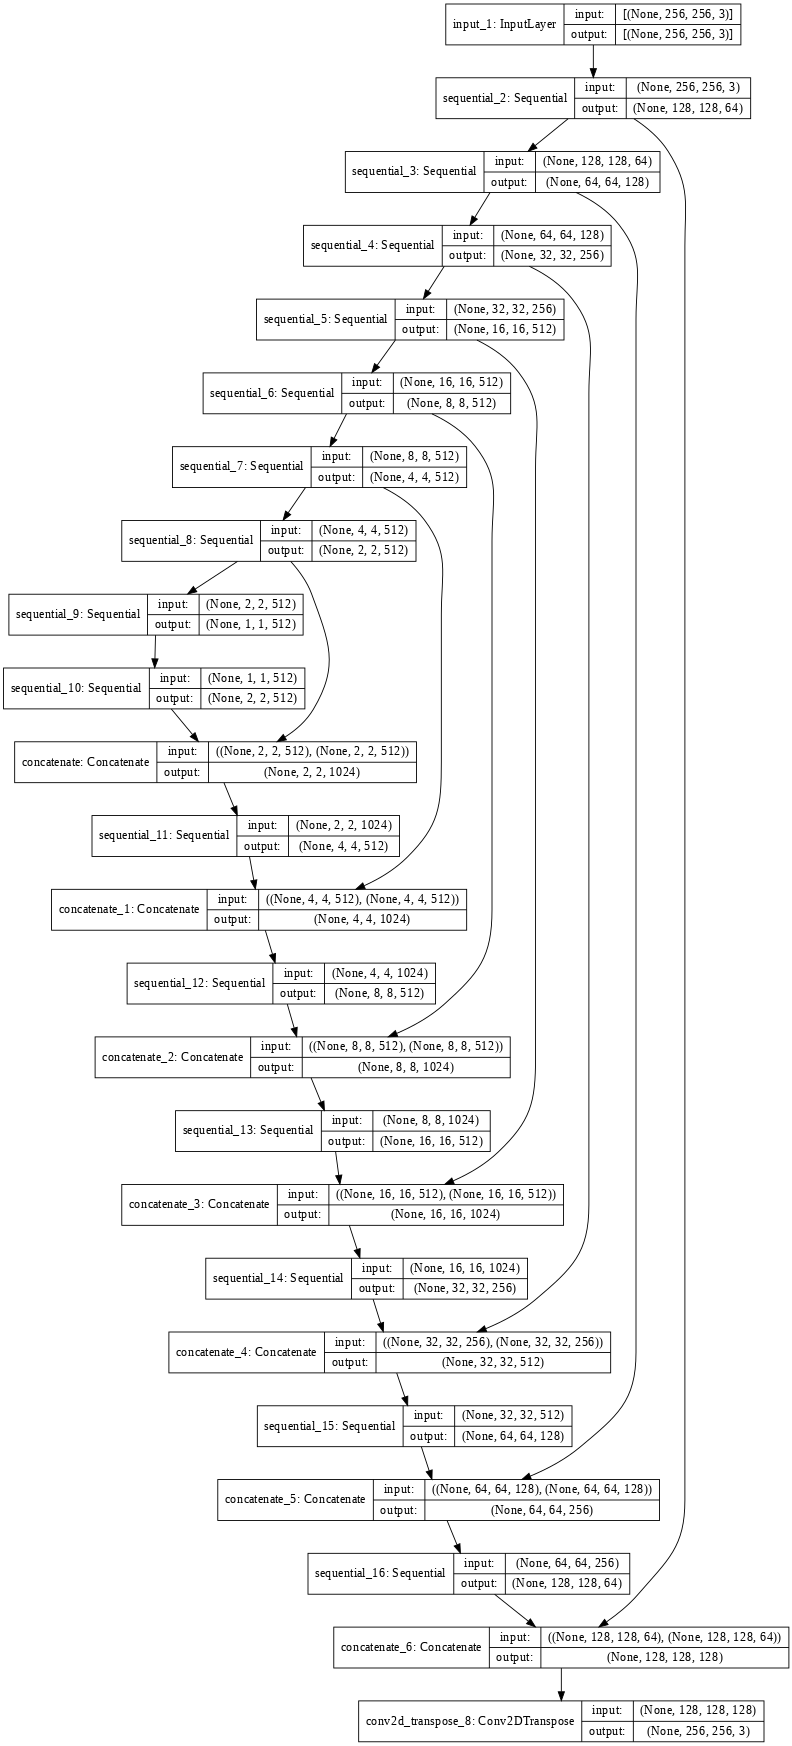

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Display the generator's output with no training

In [ ]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Exercise: Implement the generator loss function

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  ### START CODE HERE ###

  # Use loss_object to compute the loss between the discriminator-generated output
  # and a tensor of ones of the same shape
  gan_loss = loss_object(tf.ones(disc_generated_output.shape),
                         disc_generated_output)

  # Compute the mean absolute error between the target and the generator's output
  l1_loss = tf.reduce_mean(tf.abs(gen_output - target))

  # Compute the total generator loss
  total_gen_loss = gan_loss + LAMBDA * l1_loss
  
  ### END CODE HERE ###
  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [ ]:
def Discriminator():
  ### START CODE HERE ###

  # Initialize the parameters so they are normally distributed, 
  # with a mean of 0 and standard deviation of 0.02
  initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)

  # Define the input and target layers as keras input layers with shape [256,256,3]
  # Use 'input_image' for the name
  inp = tf.keras.layers.Input(shape=(256, 256, 3), name='input_image')
  # Use 'target_image' for the name
  tar = tf.keras.layers.Input(shape=(256, 256, 3), name='target_image')

  # Assemble the discriminator network sequentially, but using the keras functional API
  
  # Concatenate the input and target
  x = tf.keras.layers.concatenate((inp, tar),
                                  axis=-1) # (batch size, 256, 256, channels*2)

  # Apply 3 downsampling blocks
  # Use the output sizes to determine the first 2 arguments of each block
  # Don't apply batch normalization to the first block, but do apply it to the others
  down1 = downsample(64, 4, apply_batchnorm=False)(x) # (batch size, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (batch size, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (batch size, 32, 32, 256)

  # Apply 2D zero padding with a padding width of 1 (default)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch size, 34, 34, 256)

  # Apply a 2D convolution with 512 output channels, kernel size of 4, stride of 1, 
  # the initializer defined above, and no bias parameters
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (batch size, 31, 31, 512)

  # Apply batch normalization
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  # Apply leaky ReLU activation
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  # Apply 2D zero padding with a padding width of 1 (default)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch size, 33, 33, 512)

  # Apply a 2D convolution with 1 output channel, kernel size of 4, stride of 1, and 
  # the initializer defined above
  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (batch size, 30, 30, 1)

  ### END CODE HERE ###
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Visualize the discriminator's architecture

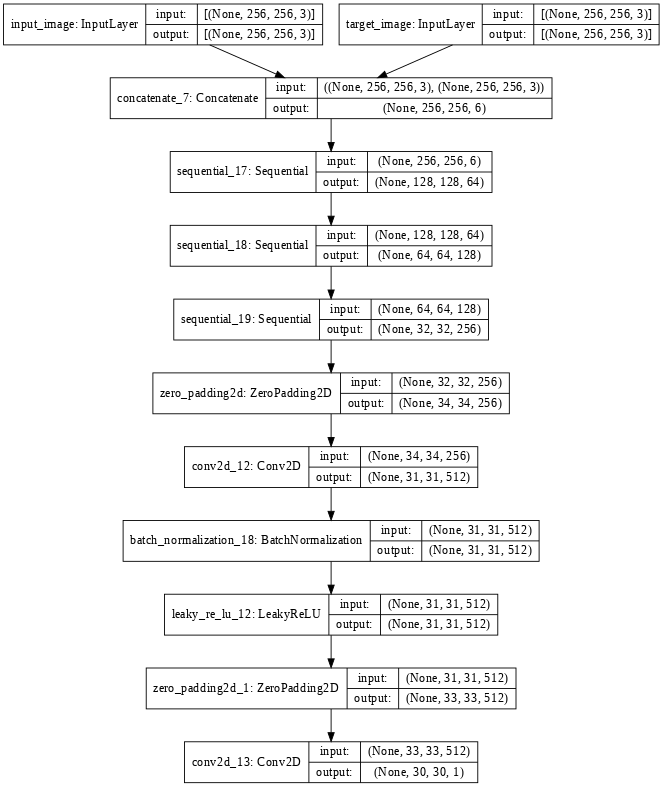

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Display the discriminator's output with no training

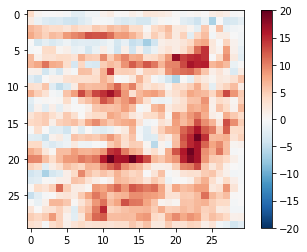

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


### Exercise: Implement the discriminator loss function

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  ### START CODE HERE ###

  # Use loss_object to compute the loss between the real image(s)
  # and a tensor of ones of the same shape
  real_loss = loss_object(tf.ones(disc_real_output.shape), disc_real_output)

  # Use loss_object to compute the loss between the discriminator-generated output
  # and a tensor of zeros of the same shape
  generated_loss = loss_object(tf.zeros(disc_generated_output.shape),
                               disc_generated_output)

  # Sum the two losses computed above
  total_disc_loss = real_loss + generated_loss

  ### END CODE HERE ###
  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [ ]:
EPOCHS = 150

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

### Exercise: Define a training epoch

You may find [`tf.GradientTape()`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) useful, particularly its [`gradient()`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) method. Likewise, you'll probably appreciate the [`apply_gradients()`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients) method of [`tf.keras.optimizers.Optimizer()`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer) (i.e. the optimizer base class).

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  ### START CODE HERE ###
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # Apply the generator to the input image, with training=True
    gen_output = generator(input_image, training=True)

    # Apply the discriminator to the (concatenated) input image and target, with training=True
    disc_real_output = discriminator([input_image, target], training=True)
    # Apply the discriminator to the (concatenated) input image and generated output, with training=True
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Compute the generator loss(es)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    # Compute the discriminator loss(es)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  
  # Compute the gradient of the total generator loss with respect to the generator's trainable_variables
  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  # Compute the gradient of the total discriminator loss with respect to the discriminator's trainable_variables
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Apply the generator gradients to the generator_optimizer
  # Zip the gradients and variables to do this
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  
  # Apply the discriminator gradients to the discriminator_optimizer
  # Zip the gradients and variables to do this
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  ### END CODE HERE ###
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

### Now run the training loop

### Warning: This takes a while

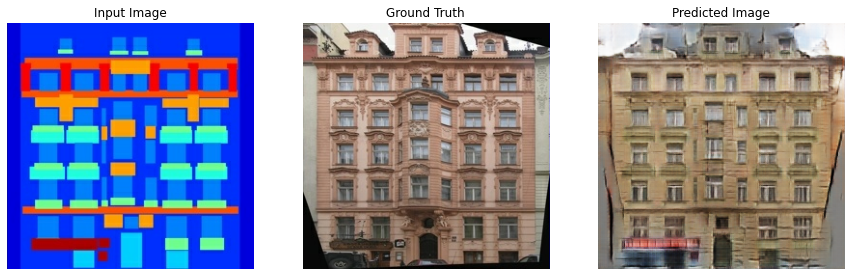

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 150 is 38.37428855895996 sec



In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

If you want to share the TensorBoard results _publicly_ you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir  {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)